<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

logs/  models/  orderparams.ipynb  OrderPresentation.gslides


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.8MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=86155fccefe512b390a7ff0f3bad442cb6c5b44ac6300ea99ed7351c89c3222e
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.7MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" important methods.

In [26]:
class OrderMethods():

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        # nllfs = []
        # zin = []
        # for tns in np.arange(50,200, 5):
        #     #print("zs", zs)
        #     model.Tn.value = tns
        #     model.update()
        #     schi=model.nllf()
        #     nllfs.append(schi)
        #     zin.append(tns)
        # plt.scatter(zin, nllfs)
        # plt.xlabel("tn in")
        # plt.ylabel("chi") 
        # plt.show()
        # plt.close()

        # model.Tn.value = 200
        # model.update()

        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [31]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env):

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.Bk = .3
        self.error = []

        self.fixedTn = 160
        self.fixedNf = 330
        self.fixedJt = .885

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        self.action_space = spaces.Discrete(7)
        self.action_options = [1, 5, 10, 15, 20, 25, 30]
        self.curTemp = 3
        self.x = 150 #startTn value

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 
        
        print("stepping: ", self.episodeNum)
        print("ACTION            : ", action)

        self.curTemp += self.action_options[action]
        #self.curTemp = action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 3:
            self.I = self.getData(self.T, self.Bk)
            #self.I = OrderMethods.getData(self.T, self.Bk)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Tn = 200, Jt = .2, Nf = 216, Bk = self.Bk)
            M.Tn.range(10, 400)
            M.Jt.range(0.4, 2)
            M.Nf.range(100,500)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.Nf = self.x[1]
            self.Jt = self.x[0]
            self.x = self.x[2]
            print("ORDER PARAM RESULT (X2):", self.x)
            print("THE JT RESULT {X0}:", self.Jt)
            print("THE NF RESULT {X1}:", self.Nf)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            plt.plot(self.T, self.I, 'ro')
            plt.show()
            plt.close()

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 :
                  reward += 100

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)
            self.Jts.append(self.Jt)
            self.Nfs.append(self.Nf)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        self.state = np.array([self.curTemp])
        delta = abs(340 - self.curTemp)

        if (self.steps > 3 and chisq < 0.05 and dx < 10000000): #less than or equal to?
            reward += 200
            print("terminated: excellent conditions")
            terminal = True
            self.log()

        elif (self.curTemp >= 340):
            print("terminated: over max temp")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False
        
        print("returned state:", self.state)
        o = self.observation_space 
        print("observation space: ", o.shape)
        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.transTemps)

        filename = "logs/jt/jtLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Jts)

        filename = "logs/nf/nfLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Nfs)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.npy"
        np.savetxt(filename, self.rewards)

    # @property
    # def action_space(self):
    #     return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
    #     # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)

    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def getData(self, T, Bk):
        return OrderMethods.orderparameter(T, self.fixedTn, self.fixedJt, self.fixedNf, Bk)

    def setTn(self, Tn):
        self.fixedTn = Tn
    
    def setNf(self, Nf):
        self.fixedNf = Nf

    def setJt(self, Jt):
        self.fixedJt = Jt

    def getTn(self):
        return self.x

    def getNf(self):
        return self.Nf

    def getJt(self):
        return self.Jt

In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [29]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

Train a new model.

In [ ]:
model = PPO2('MlpPolicy', env, verbose=1).learn(15000)

In [ ]:
model.save("models/")

Restart the training from a saved model.

In [ ]:
model = PPO2.load("models/3245_first_attempt", env)  #if needed, instatiate env above
model = model.learn(500)

Test the trained agent.

Loading a model without an environment, this model cannot be trained until it has a valid environment.
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123.0
Temperature:  [ 33.  63.  93. 123.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.25928

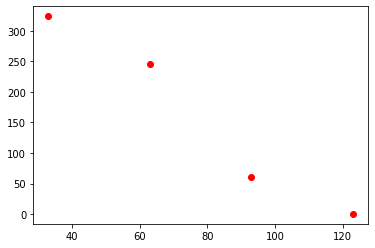

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 194.84580800906008
THE JT RESULT {X0}: 1.9998611543811622
THE NF RESULT {X1}: 208.11844936236199
chisqds:  45183.42788658793
BUT ARE WE SURE?: 9.251989122670268e-10


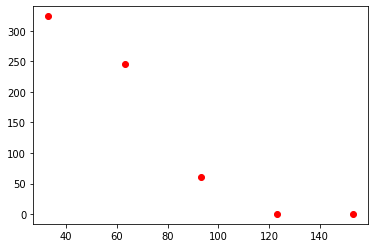

highHIIIIGHHHHHH:  187.0
rewaRD::  -100
returned state: [153.]
observation space:  (6,)
obs= [[153.]] reward= [-100.] done= [False]
Step 6
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  183.0
Temperature:  [ 33.  63.  93. 123. 153. 183.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.47382734127325
THE JT RESULT {X0}: 1.9998691659137653
THE NF RESULT {X1}: 181.11513907325482
chisqds:  20253.8669498603
BUT ARE WE SURE?: 1.040260176914606e-09


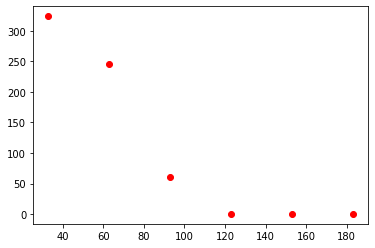

highHIIIIGHHHHHH:  157.0
rewaRD::  -100
returned state: [183.]
observation space:  (7,)
obs= [[183.]] reward= [-100.] done= [False]
Step 7
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  213.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.10173555106297
THE JT RESULT {X0}: 1.9999826431914172
THE NF RESULT {X1}: 165.265924223555
chisqds:  11654.464396115745
BUT ARE WE SURE?: 1.1558926895228878e-09


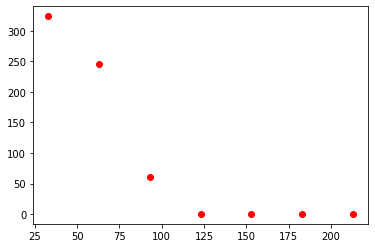

highHIIIIGHHHHHH:  127.0
rewaRD::  -100
returned state: [213.]
observation space:  (8,)
obs= [[213.]] reward= [-100.] done= [False]
Step 8
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  243.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.42669498147592
THE JT RESULT {X0}: 1.999850784873936
THE NF RESULT {X1}: 166.40734453417463
chisqds:  9528.549068009104
BUT ARE WE SURE?: 1.2714002642768965e-09


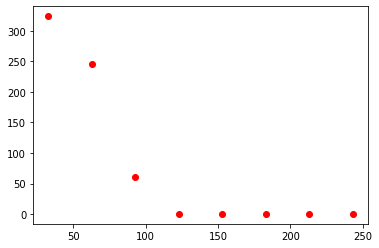

highHIIIIGHHHHHH:  97.0
rewaRD::  -100
returned state: [243.]
observation space:  (9,)
obs= [[243.]] reward= [-100.] done= [False]
Step 9
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  273.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.87038812564853
THE JT RESULT {X0}: 1.9998939864001233
THE NF RESULT {X1}: 167.05515422719432
chisqds:  8089.9452409338255
BUT ARE WE SURE?: 1.3870146457754689e-09


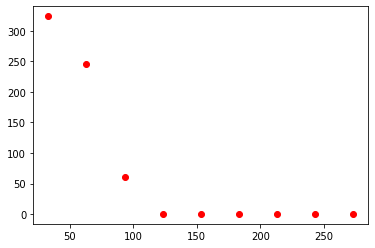

highHIIIIGHHHHHH:  67.0
rewaRD::  -100
returned state: [273.]
observation space:  (10,)
obs= [[273.]] reward= [-100.] done= [False]
Step 10
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  303.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.72102952865296
THE JT RESULT {X0}: 1.9999411675930696
THE NF RESULT {X1}: 180.00629592644836
chisqds:  8625.561595238849
BUT ARE WE SURE?: 1.5026537150107702e-09


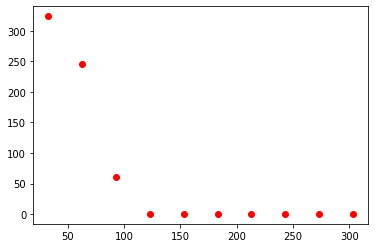

highHIIIIGHHHHHH:  37.0
rewaRD::  -100
returned state: [303.]
observation space:  (11,)
obs= [[303.]] reward= [-100.] done= [False]
Step 11
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  333.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 191.35023076883536
THE JT RESULT {X0}: 1.999964395555472
THE NF RESULT {X1}: 191.0234314221731
chisqds:  9044.157729998533
BUT ARE WE SURE?: 1.618279559986231e-09


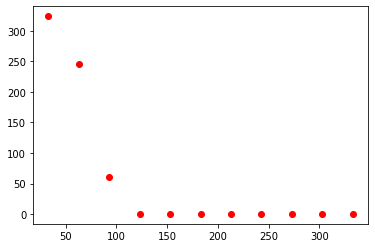

highHIIIIGHHHHHH:  7.0
rewaRD::  -100
returned state: [333.]
observation space:  (12,)
obs= [[333.]] reward= [-100.] done= [False]
Step 12
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  363.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333. 363.]
Intensity:  [3.23997235e+02 2.46507857e+02 6.02319199e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 180.81589387974134
THE JT RESULT {X0}: 1.9998702246770559
THE NF RESULT {X1}: 164.8538028798958
chisqds:  4627.987860412391
BUT ARE WE SURE?: 1.7346274220467144e-09


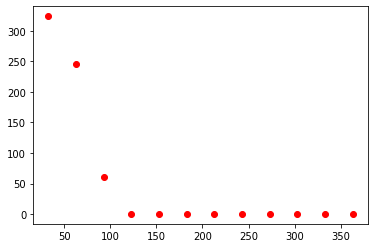

highHIIIIGHHHHHH:  -23.0
rewaRD::  -100
terminated: over max temp
returned state: [363.]
observation space:  (13,)
reset
obs= [[3.]] reward= [-100.] done= [ True]
second gettn:    180.81589387974134
Goal reached! reward= [-100.]
Fail for tn: 100
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123.0
T

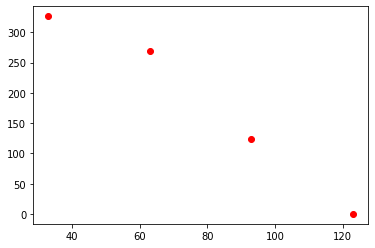

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 194.7573696827372
THE JT RESULT {X0}: 1.9999234269241148
THE NF RESULT {X1}: 208.04245349873204
chisqds:  44984.2853715177
BUT ARE WE SURE?: 9.202484679933448e-10


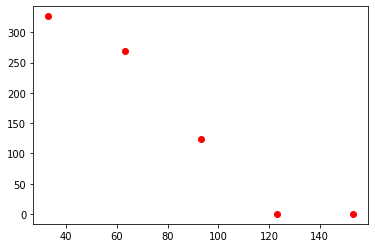

highHIIIIGHHHHHH:  187.0
rewaRD::  -100
returned state: [153.]
observation space:  (6,)
obs= [[153.]] reward= [-100.] done= [False]
Step 6
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  183.0
Temperature:  [ 33.  63.  93. 123. 153. 183.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.36756143430523
THE JT RESULT {X0}: 1.9999695437004126
THE NF RESULT {X1}: 180.94099009430778
chisqds:  20126.229075044084
BUT ARE WE SURE?: 1.0341883209175922e-09


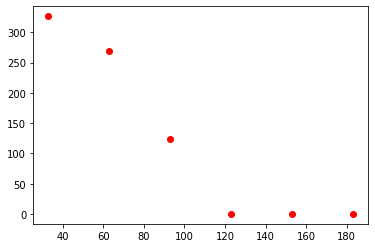

highHIIIIGHHHHHH:  157.0
rewaRD::  -100
returned state: [183.]
observation space:  (7,)
obs= [[183.]] reward= [-100.] done= [False]
Step 7
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  213.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.00093619215016
THE JT RESULT {X0}: 1.9998223650330873
THE NF RESULT {X1}: 165.0374272470383
chisqds:  11575.512538783962
BUT ARE WE SURE?: 1.1489953105709538e-09


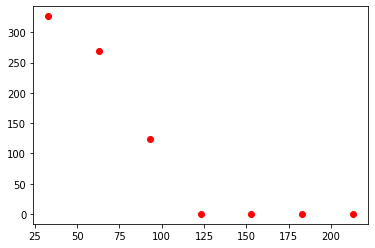

highHIIIIGHHHHHH:  127.0
rewaRD::  -100
returned state: [213.]
observation space:  (8,)
obs= [[213.]] reward= [-100.] done= [False]
Step 8
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  243.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.33651104443288
THE JT RESULT {X0}: 1.9999568068347482
THE NF RESULT {X1}: 166.27729872843625
chisqds:  9477.2164639928
BUT ARE WE SURE?: 1.2639821208362845e-09


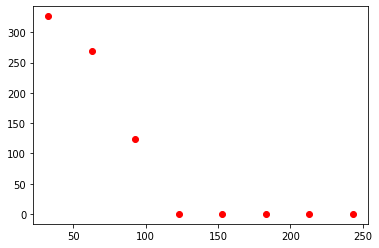

highHIIIIGHHHHHH:  97.0
rewaRD::  -100
returned state: [243.]
observation space:  (9,)
obs= [[243.]] reward= [-100.] done= [False]
Step 9
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  273.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.77526893810068
THE JT RESULT {X0}: 1.9999208119753948
THE NF RESULT {X1}: 166.8803385389313
chisqds:  8041.236231548995
BUT ARE WE SURE?: 1.3788671934756276e-09


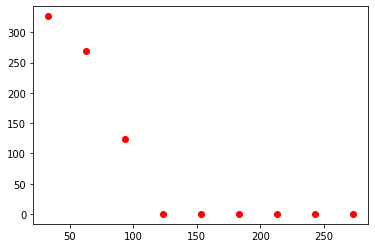

highHIIIIGHHHHHH:  67.0
rewaRD::  -100
returned state: [273.]
observation space:  (10,)
obs= [[273.]] reward= [-100.] done= [False]
Step 10
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  303.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.71391296742604
THE JT RESULT {X0}: 1.9999891444535292
THE NF RESULT {X1}: 180.20829046704998
chisqds:  8627.772326167624
BUT ARE WE SURE?: 1.4938445812205205e-09


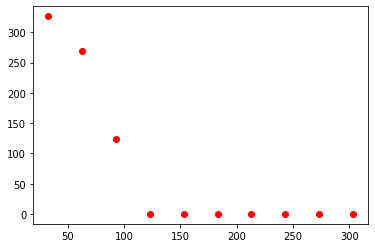

highHIIIIGHHHHHH:  37.0
rewaRD::  -100
returned state: [303.]
observation space:  (11,)
obs= [[303.]] reward= [-100.] done= [False]
Step 11
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  333.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 191.3622232622733
THE JT RESULT {X0}: 1.9998205445541162
THE NF RESULT {X1}: 191.2842013132385
chisqds:  9054.403836372392
BUT ARE WE SURE?: 1.6086401108409577e-09


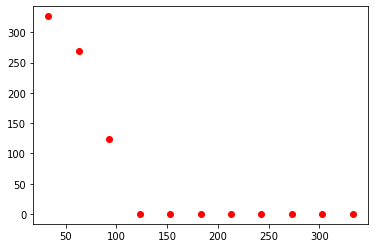

highHIIIIGHHHHHH:  7.0
rewaRD::  -100
returned state: [333.]
observation space:  (12,)
obs= [[333.]] reward= [-100.] done= [False]
Step 12
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  363.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333. 363.]
Intensity:  [3.26472537e+02 2.69361707e+02 1.24231350e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 180.7115592094444
THE JT RESULT {X0}: 1.9998594435586106
THE NF RESULT {X1}: 164.99166583664632
chisqds:  4615.395322296633
BUT ARE WE SURE?: 1.7252651243596291e-09


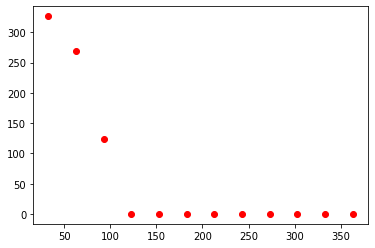

highHIIIIGHHHHHH:  -23.0
rewaRD::  -100
terminated: over max temp
returned state: [363.]
observation space:  (13,)
reset
obs= [[3.]] reward= [-100.] done= [ True]
second gettn:    180.7115592094444
Goal reached! reward= [-100.]
Fail for tn: 110
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123.0
Te

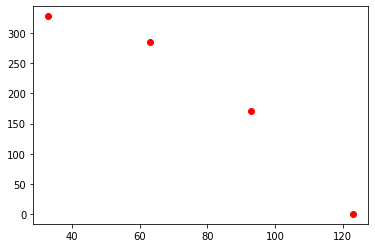

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 194.73611704906767
THE JT RESULT {X0}: 1.9998195684962916
THE NF RESULT {X1}: 208.02896314908074
chisqds:  44956.00484899426
BUT ARE WE SURE?: 9.186984781718313e-10


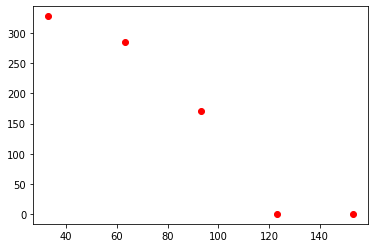

highHIIIIGHHHHHH:  187.0
rewaRD::  -100
returned state: [153.]
observation space:  (6,)
obs= [[153.]] reward= [-100.] done= [False]
Step 6
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  183.0
Temperature:  [ 33.  63.  93. 123. 153. 183.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.33204480340535
THE JT RESULT {X0}: 1.9998971008231388
THE NF RESULT {X1}: 180.87767986134907
chisqds:  20098.24667773495
BUT ARE WE SURE?: 1.0083972065377042e-09


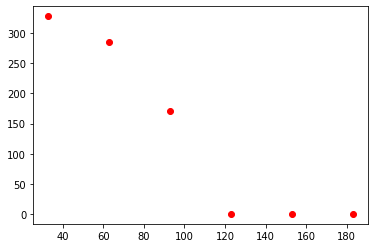

highHIIIIGHHHHHH:  157.0
rewaRD::  -100
returned state: [183.]
observation space:  (7,)
obs= [[183.]] reward= [-100.] done= [False]
Step 7
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  213.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 184.94849482182028
THE JT RESULT {X0}: 1.9998997563148362
THE NF RESULT {X1}: 164.88919390070046
chisqds:  11544.561551352775
BUT ARE WE SURE?: 1.1204173860210967e-09


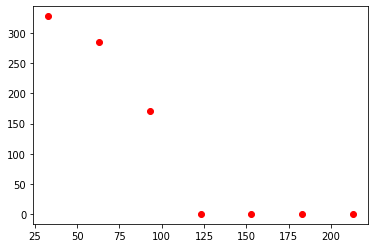

highHIIIIGHHHHHH:  127.0
rewaRD::  -100
returned state: [213.]
observation space:  (8,)
obs= [[213.]] reward= [-100.] done= [False]
Step 8
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  243.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.31066990291598
THE JT RESULT {X0}: 1.999979768718032
THE NF RESULT {X1}: 166.24816031603234
chisqds:  9471.529763955488
BUT ARE WE SURE?: 1.2325122562837503e-09


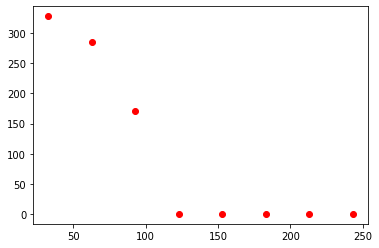

highHIIIIGHHHHHH:  97.0
rewaRD::  -100
returned state: [243.]
observation space:  (9,)
obs= [[243.]] reward= [-100.] done= [False]
Step 9
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  273.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.74768089888408
THE JT RESULT {X0}: 1.9998208514679903
THE NF RESULT {X1}: 166.83603221999175
chisqds:  8034.672052109949
BUT ARE WE SURE?: 1.3444545840426213e-09


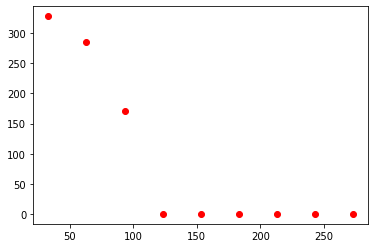

highHIIIIGHHHHHH:  67.0
rewaRD::  -100
returned state: [273.]
observation space:  (10,)
obs= [[273.]] reward= [-100.] done= [False]
Step 10
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  303.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 188.7119717296185
THE JT RESULT {X0}: 1.9998618094339464
THE NF RESULT {X1}: 180.27324899384286
chisqds:  8635.093209972392
BUT ARE WE SURE?: 1.4565517655009615e-09


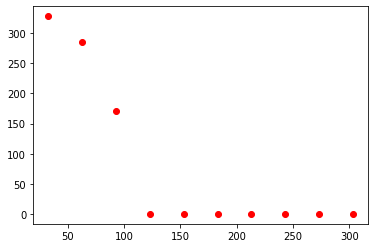

highHIIIIGHHHHHH:  37.0
rewaRD::  -100
returned state: [303.]
observation space:  (11,)
obs= [[303.]] reward= [-100.] done= [False]
Step 11
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  333.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 191.36486757693177
THE JT RESULT {X0}: 1.9999287725631785
THE NF RESULT {X1}: 191.36149621948562
chisqds:  9062.296261267866
BUT ARE WE SURE?: 1.5686764153984565e-09


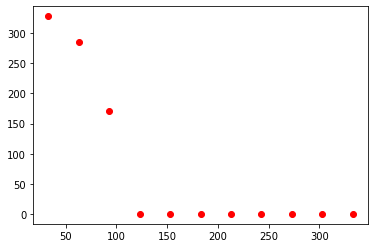

highHIIIIGHHHHHH:  7.0
rewaRD::  -100
returned state: [333.]
observation space:  (12,)
obs= [[333.]] reward= [-100.] done= [False]
Step 12
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  363.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333. 363.]
Intensity:  [3.27962977e+02 2.85397022e+02 1.70616372e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 180.37715243737694
THE JT RESULT {X0}: 1.9998383056814333
THE NF RESULT {X1}: 165.5795954975009
chisqds:  4609.468626317281
BUT ARE WE SURE?: 1.6912932116164295e-09


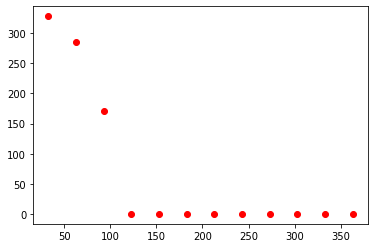

highHIIIIGHHHHHH:  -23.0
rewaRD::  -100
terminated: over max temp
returned state: [363.]
observation space:  (13,)
reset
obs= [[3.]] reward= [-100.] done= [ True]
second gettn:    180.37715243737694
Goal reached! reward= [-100.]
Fail for tn: 120
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123.0
T

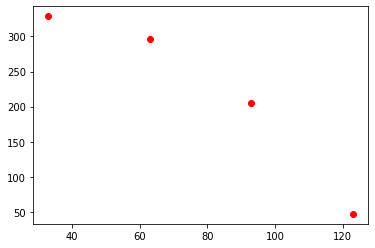

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 192.39510086175576
THE JT RESULT {X0}: 1.9998187823997151
THE NF RESULT {X1}: 199.16583614563368
chisqds:  11413.717650340699
BUT ARE WE SURE?: 9.167439550870205e-10


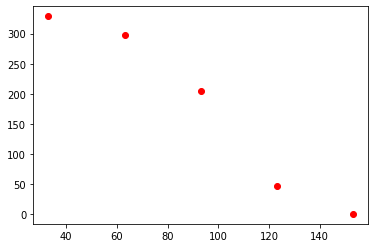

highHIIIIGHHHHHH:  187.0
rewaRD::  -100
returned state: [153.]
observation space:  (6,)
obs= [[153.]] reward= [-100.] done= [False]
Step 6
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  183.0
Temperature:  [ 33.  63.  93. 123. 153. 183.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 189.91505406492016
THE JT RESULT {X0}: 1.9999105871504934
THE NF RESULT {X1}: 176.03724048948033
chisqds:  5686.7667687608655
BUT ARE WE SURE?: 8.980641105554531e-10


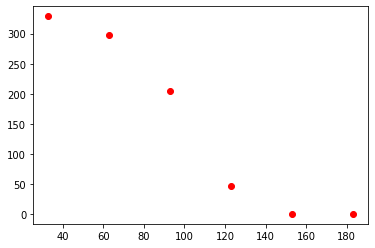

highHIIIIGHHHHHH:  157.0
rewaRD::  -100
returned state: [183.]
observation space:  (7,)
obs= [[183.]] reward= [-100.] done= [False]
Step 7
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  213.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 184.55095330974075
THE JT RESULT {X0}: 1.999812555805569
THE NF RESULT {X1}: 142.61184098360363
chisqds:  2186.4522350662514
BUT ARE WE SURE?: 9.977727852835065e-10


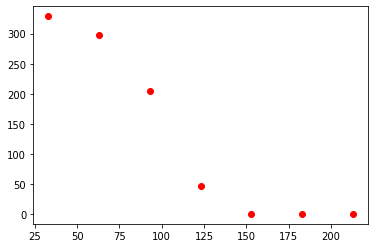

highHIIIIGHHHHHH:  127.0
rewaRD::  -100
returned state: [213.]
observation space:  (8,)
obs= [[213.]] reward= [-100.] done= [False]
Step 8
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  243.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 182.03310284159983
THE JT RESULT {X0}: 1.9998282275591317
THE NF RESULT {X1}: 124.33670351745567
chisqds:  1197.0821933658158
BUT ARE WE SURE?: 1.25998083712942e-09


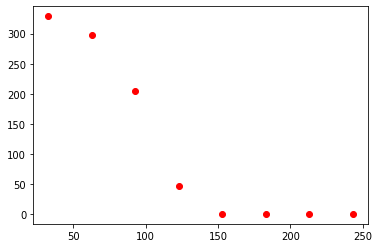

highHIIIIGHHHHHH:  97.0
rewaRD::  -100
returned state: [243.]
observation space:  (9,)
obs= [[243.]] reward= [-100.] done= [False]
Step 9
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  273.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.84677457435126
THE JT RESULT {X0}: 1.9999112639534782
THE NF RESULT {X1}: 149.36338960312787
chisqds:  1696.822297162966
BUT ARE WE SURE?: 1.197394630156313e-09


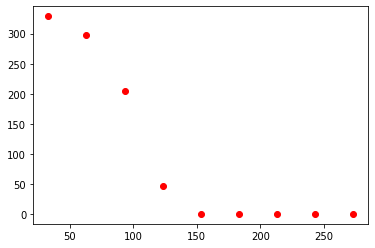

highHIIIIGHHHHHH:  67.0
rewaRD::  -100
returned state: [273.]
observation space:  (10,)
obs= [[273.]] reward= [-100.] done= [False]
Step 10
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  303.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 185.30445938126326
THE JT RESULT {X0}: 1.9999668244755526
THE NF RESULT {X1}: 144.60683160477996
chisqds:  1331.0032804014934
BUT ARE WE SURE?: 1.2972118725202125e-09


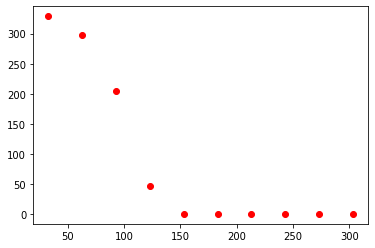

highHIIIIGHHHHHH:  37.0
rewaRD::  -100
returned state: [303.]
observation space:  (11,)
obs= [[303.]] reward= [-100.] done= [False]
Step 11
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  333.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.19690156674756
THE JT RESULT {X0}: 1.9999126516198926
THE NF RESULT {X1}: 174.0445909947214
chisqds:  2113.0537772301695
BUT ARE WE SURE?: 1.396993708744602e-09


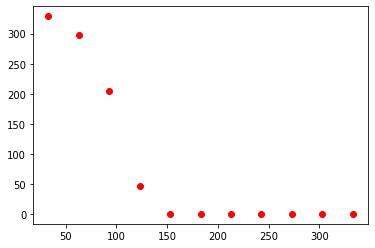

highHIIIIGHHHHHH:  7.0
rewaRD::  -100
returned state: [333.]
observation space:  (12,)
obs= [[333.]] reward= [-100.] done= [False]
Step 12
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  363.0
Temperature:  [ 33.  63.  93. 123. 153. 183. 213. 243. 273. 303. 333. 363.]
Intensity:  [3.28867779e+02 2.96868861e+02 2.04982261e+02 4.69616259e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 192.5762238651771
THE JT RESULT {X0}: 1.9999706193203604
THE NF RESULT {X1}: 186.94696709982645
chisqds:  2411.5309943541774
BUT ARE WE SURE?: 1.496842561339262e-09


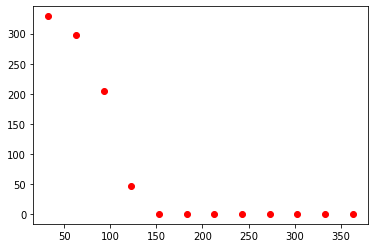

highHIIIIGHHHHHH:  -23.0
rewaRD::  -100
terminated: over max temp
returned state: [363.]
observation space:  (13,)
reset
obs= [[3.]] reward= [-100.] done= [ True]
second gettn:    192.5762238651771
Goal reached! reward= [-100.]
Fail for tn: 130
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123.0
Te

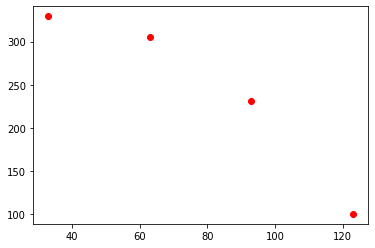

highHIIIIGHHHHHH:  217.0
rewaRD::  0
terminated: excellent conditions
returned state: [123.]
observation space:  (5,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    139.99999999999017
Goal reached! reward= [200.]
Success for tn:  140
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  12

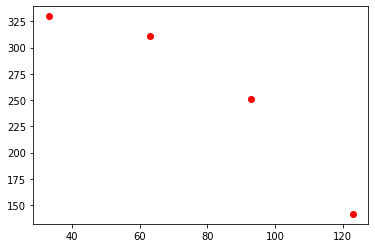

highHIIIIGHHHHHH:  217.0
rewaRD::  0
terminated: excellent conditions
returned state: [123.]
observation space:  (5,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    150.00000000006222
Goal reached! reward= [200.]
Success for tn:  150
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  12

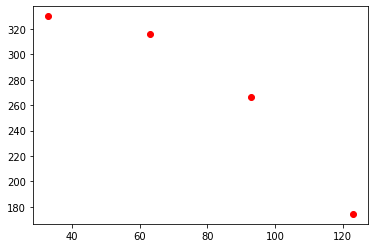

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [329.96643649 315.89652018 266.21196364 174.42840034  38.49727682]
ORDER PARAM RESULT (X2): 159.99999999999278
THE JT RESULT {X0}: 0.8850000000000318
THE NF RESULT {X1}: 329.9999999999997
chisqds:  1.8039423773416034e-23
BUT ARE WE SURE?: 0.5676192224990027


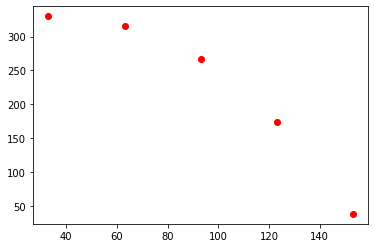

highHIIIIGHHHHHH:  187.0
rewaRD::  0
terminated: excellent conditions
returned state: [153.]
observation space:  (6,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    159.99999999999278
Goal reached! reward= [200.]
Success for tn:  160
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  12

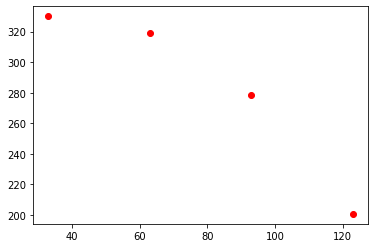

highHIIIIGHHHHHH:  217.0
rewaRD::  0
terminated: excellent conditions
returned state: [123.]
observation space:  (5,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    169.9999999999843
Goal reached! reward= [200.]
Success for tn:  170
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123

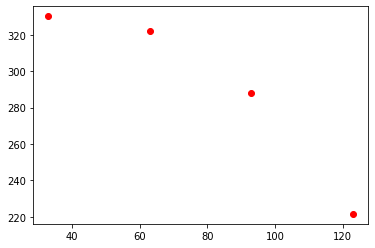

highHIIIIGHHHHHH:  217.0
rewaRD::  0
terminated: excellent conditions
returned state: [123.]
observation space:  (5,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    179.9999999999998
Goal reached! reward= [200.]
Success for tn:  180
reset
Step 1
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
obs= [[33.]] reward= [-100.] done= [False]
Step 2
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
obs= [[63.]] reward= [-100.] done= [False]
Step 3
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  93.0
Temperature:  [33. 63. 93.]
highHIIIIGHHHHHH:  247.0
rewaRD::  -100
returned state: [93.]
observation space:  (4,)
obs= [[93.]] reward= [-100.] done= [False]
Step 4
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  123

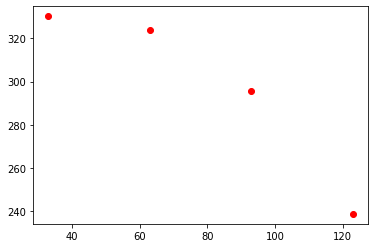

highHIIIIGHHHHHH:  217.0
rewaRD::  -100
returned state: [123.]
observation space:  (5,)
obs= [[123.]] reward= [-100.] done= [False]
Step 5
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  153.0
Temperature:  [ 33.  63.  93. 123. 153.]
Intensity:  [330.22173941 323.84459756 295.58912036 238.78855846 151.46162079]
ORDER PARAM RESULT (X2): 200.52978351748624
THE JT RESULT {X0}: 0.400000207050904
THE NF RESULT {X1}: 217.49016652122208
chisqds:  59.837324064950046
BUT ARE WE SURE?: 1.608847384994354


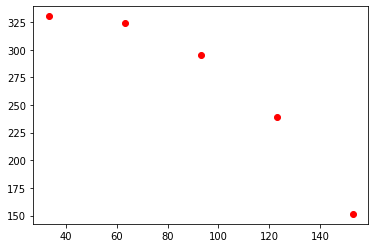

highHIIIIGHHHHHH:  187.0
rewaRD::  -100
returned state: [153.]
observation space:  (6,)
obs= [[153.]] reward= [-100.] done= [False]
Step 6
Action:  [6]
stepping:  0
ACTION            :  6
curtemp:  183.0
Temperature:  [ 33.  63.  93. 123. 153. 183.]
Intensity:  [330.22173941 323.84459756 295.58912036 238.78855846 151.46162079
  32.63021518]
ORDER PARAM RESULT (X2): 190.00000000000048
THE JT RESULT {X0}: 0.8850000000000428
THE NF RESULT {X1}: 330.0000000000007
chisqds:  3.185430420620838e-26
BUT ARE WE SURE?: 0.49923991457001293


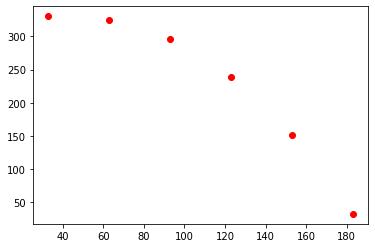

highHIIIIGHHHHHH:  157.0
rewaRD::  0
terminated: excellent conditions
returned state: [183.]
observation space:  (7,)
reset
obs= [[3.]] reward= [200.] done= [ True]
second gettn:    190.00000000000048
Goal reached! reward= [200.]
Success for tn:  190
100  :  0
110  :  0
120  :  0
130  :  0
140  :  1
150  :  1
160  :  1
170  :  1
180  :  1
190  :  1


In [37]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

successes = {}

model = PPO2.load("models/3245_first_attempt") #if you're 'playing' a saved model
for tns in np.arange(100,200, 10):
    env = OrderEnv() 
    env.setTn(tns)
    # wrap it
    vec_env = make_vec_env(lambda: env, n_envs=1) 
    finalTn = 0

    obs = vec_env.reset()
    n_steps = 20
    for step in range(n_steps):
      action, _ = model.predict(obs, deterministic=True)
      print("Step {}".format(step + 1))
      print("Action: ", action)
      obs, reward, done, info = vec_env.step(action)
      print('obs=', obs, 'reward=', reward, 'done=', done)
      if done:
        print("second gettn:   ", env.getTn())
        finalTn = env.getTn()
        print("Goal reached!", "reward=", reward)
        break

    if abs(finalTn - tns) < 0.1:
      print("Success for tn: ", tns)
      successes[tns] = 1
    else:
      print("Fail for tn:", tns)
      successes[tns] = 0

for key, value in successes.items():
    print(key, ' : ', value)

Graph the results of the training time.

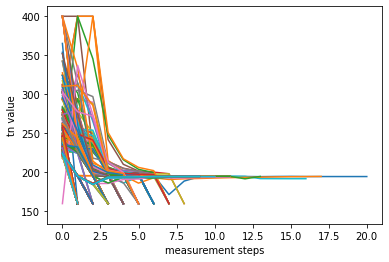

convergence for tn


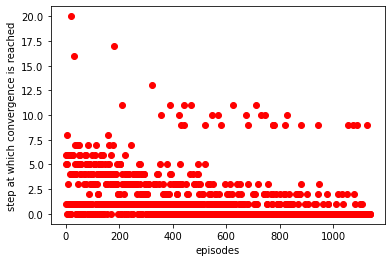

convergence for nf


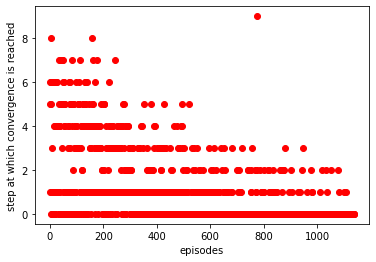

convergence for jt


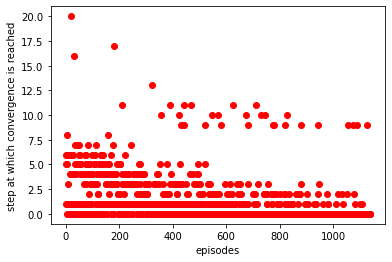

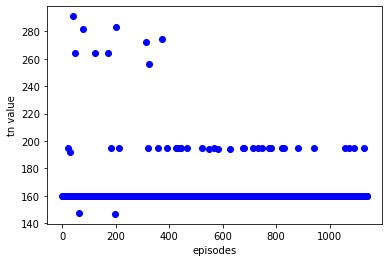

final nfs


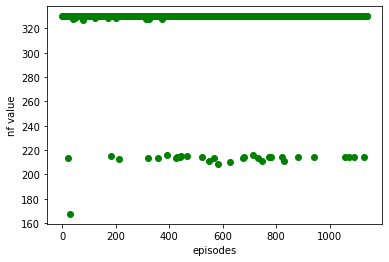

final jts


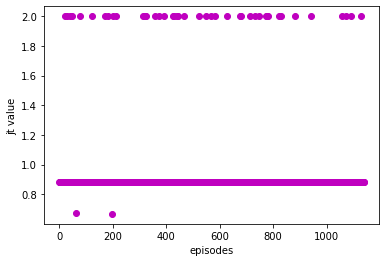

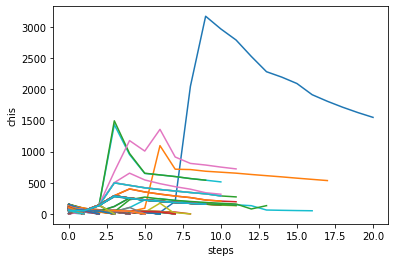

rewards at the end of the episode


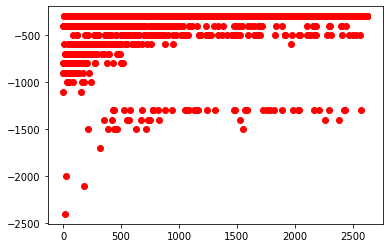

In [ ]:
numTrials = 1140

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
nfs = [[] for i in range(numTrials)]
jts = [[] for i in range(numTrials)]
endtns = []
endnfs = []
endjts = []
tn = 160
nf = 216
jt = .2
convergs_tn = []
convergs_nf = []
convergs_jt = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".npy")
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".npy")
    nfs[i-1] = np.loadtxt(logstore + "nf/nfLog-" + str(i) + ".npy")
    jts[i-1] = np.loadtxt(logstore + "jt/jtLog-" + str(i) + ".npy")

#plot each episode tn track, process ending values for plotting below
for i in range (0, len(data)): 
    j = 0
    try: 
      while j < len(data[i]) - 1 and data[i][j] > tn + 0.1 or data[i][j] < tn - 0.1:
        j += 1
    except: 
      j = 0
    
    w = 0
    try: 
      while w < len(nfs[i]) - 1 and nfs[i][w] > nf + 0.1 or nfs[i][w] < nf - 0.1:
        w += 1
    except: 
      w = 0
    
    k = 0
    try: 
      while k < len(jts[i]) - 1 and jts[i][k] > jt + 0.1 or jts[i][k] < jt - 0.1:
        k += 1
    except: 
      k = 0
    
    convergs_tn.append(j)
    convergs_nf.append(w)
    convergs_jt.append(k)

    plt.plot(data[i], label = str(i))

    try:
      value = data[i][-1]
    except:
      value = data[i]
    try:
      nf = nfs[i][-1]
    except:
      nf = nfs[i]
    try:
      jt = jts[i][-1]
    except:
      jt = jts[i]

    #print(value)
    endtns.append(value)
    endnfs.append(nf)
    endjts.append(jt)
    #print(endtns)

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()

print("convergence for tn")
plt.plot(convergs_tn, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_tn.png')

print("convergence for nf")
plt.plot(convergs_nf, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_nf.png')

print("convergence for jt")
plt.plot(convergs_jt, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_jt.png')

#actually plot final tn values for each episode
plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

print("final nfs")
plt.plot(endnfs, 'go')
plt.xlabel("episodes")
plt.ylabel("nf value")
plt.show()
plt.savefig(imagestore + "endnfs.png")
plt.close()

print("final jts")
plt.plot(endjts, 'mo')
plt.xlabel("episodes")
plt.ylabel("jt value")
plt.show()
plt.savefig(imagestore + "endjts.png")
plt.close()

#track chisq values through the episode
for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()


print("rewards at the end of the episode")
rewards = np.loadtxt('logs/runrewards.npy')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


Test how a classical fitter works.

temperature:  [  3   7  11  15  19  23  27  31  35  39  43  47  51  55  59  63  67  71
  75  79  83  87  91  95  99 103 107 111 115 119 123 127 131 135 139 143
 147 151 155 159 163 167 171 175 179 183 187 191 195 199 203 207 211 215
 219 223 227 231 235 239 243 247 251 255 259 263 267 271 275 279 283 287
 291 295 299]
Intensity:  [3.30300000e+02 3.30300000e+02 3.30300000e+02 3.30299968e+02
 3.30298873e+02 3.30288400e+02 3.30240148e+02 3.30097540e+02
 3.29780585e+02 3.29198527e+02 3.28262096e+02 3.26891299e+02
 3.25018669e+02 3.22589434e+02 3.19560107e+02 3.15896520e+02
 3.11571865e+02 3.06564979e+02 3.00858961e+02 2.94440090e+02
 2.87297081e+02 2.79420348e+02 2.70801736e+02 2.61434116e+02
 2.51311176e+02 2.40427213e+02 2.28777201e+02 2.16356427e+02
 2.03160611e+02 1.89185814e+02 1.74428400e+02 1.58884980e+02
 1.42552440e+02 1.25427847e+02 1.07508512e+02 8.87918924e+01
 6.92756680e+01 4.89576161e+01 2.78357095e+01 5.90802675e+00
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-

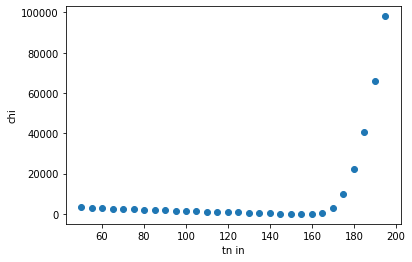

[160.]


In [ ]:
p=[.885,330,.3]
T=np.arange(3, 300, 4)
#T = np.array([14.5, 15])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.close()